# Snow extent boxplots and errors calculations

## Objectif

L'objectif de ce notebook est de comparer la couverture neigeuse simulée par chaque modèle avec celle des observations. En parrallèle, les erreurs absolues vont être calculées et comparées. Cela va permettre de déterminer les modèles aberrants qu'il sera nécessaire d'exclure ou de prendre moins en considération dans les analyses futures. Enfin, des fonctions de score ont été testées afin de regarder laquelle pénalise le plus les mauvais modèles. Ainsi, ce notebook présente l'ensemble des analyses statistiques.

In [1]:
from watermark import watermark
%load_ext watermark
print(watermark())

Last updated: 2025-07-07T06:59:57.800792+00:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.17.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
import sys
import os

# Chemin absolu vers le dossier codes_ORL_evaluation
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Ajout du chemin au sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Projet root ajouté au path:", project_root)

Projet root ajouté au path: /home/jovyan/M2_Snow_project/notebooks/codes_ORL_evaluation


In [3]:
pip install cdo

  Using cached cdo-1.6.1-py3-none-any.whl.metadata (14 kB)
Using cached cdo-1.6.1-py3-none-any.whl (16 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
from module import *

/srv/conda/envs/notebook/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [5]:
%watermark --iversions

xesmf     : 0.8.8
xarray    : 2025.1.1
sys       : 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:24:40) [GCC 13.3.0]
skimage   : 0.25.0
matplotlib: 3.10.0
cartopy   : 0.24.0
pandas    : 2.2.3
netCDF4   : 1.7.2
csv       : 1.0
numpy     : 2.0.2
watermark : 2.5.0
cdo       : 1.6.1
seaborn   : 0.13.2



## Snow reference

In [6]:
# reference grid
path = "/home/jovyan/private-storage/grid/"
file = "nhsce_mon.v01r01_19661004_20250303_1.0x1.0.nc"
ref_grid = xr.open_dataset(os.path.join(path, file))

In [7]:
# good areas 
path = "/home/jovyan/private-storage/grid/"
file = "area.nc"
area = xr.open_dataset(os.path.join(path, file))

In [8]:
# selection of the reference period
ref_grid = ref_grid.sel(time=slice("1995", "2014"))

### Snow extension by month

In [9]:
snow_cover = ref_grid["snow_cover_extent"]

snow_cover = snow_cover.groupby("time.month").mean(dim="time")

In [10]:
cell_area = area["cell_area"]

snow_cover_km2 = (snow_cover * (cell_area * 1e-6) ).groupby(snow_cover["month"]).sum(dim=["lat", "lon"], skipna=True)

print(snow_cover_km2)
print(snow_cover_km2.shape)

<xarray.DataArray (month: 12)> Size: 96B
array([47527339.11645807, 47170685.33438697, 41034269.29181223,
       32014146.33675294, 19553457.31518154,  9003870.52668834,
        3134122.09805531,  2460193.82986189,  4226952.56887794,
       17861365.62524626, 34152238.95970662, 44012796.3253699 ])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
(12,)


## Représentation graphique de l'extension mensuelle moyenne de la neige (fichiers historiques)

In [11]:
snow_hist = pd.read_csv("snow_cover_par_modele.csv")
snow_hist

,modèle,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,EC-Earth3-Veg,5.953257e+07,5.827893e+07,5.410618e+07,4.531498e+07,3.290839e+07,1.831443e+07,6.660904e+06,6.732384e+06,1.707768e+07,3.508417e+07,4.950251e+07,5.718891e+07
1,CNRM-ESM2-1,5.369965e+07,5.340618e+07,4.654606e+07,3.266167e+07,1.640322e+07,5.168239e+06,2.816770e+06,2.508564e+06,4.445377e+06,1.622590e+07,3.331676e+07,4.719822e+07
2,MIROC6,5.266020e+07,5.094570e+07,4.508776e+07,3.349808e+07,1.774217e+07,4.154948e+06,1.295355e+06,1.682480e+06,5.691421e+06,2.037477e+07,3.595682e+07,4.789852e+07
3,CIESM,4.772395e+07,4.634545e+07,4.033531e+07,2.914981e+07,1.660809e+07,5.306691e+06,1.942934e+06,1.509078e+06,2.631251e+06,1.352317e+07,3.092356e+07,4.299549e+07
4,CNRM-CM6-1-HR,5.424420e+07,5.411872e+07,4.791415e+07,3.332174e+07,1.705687e+07,6.009408e+06,3.486442e+06,3.384404e+06,6.117203e+06,1.874844e+07,3.613690e+07,4.875330e+07
5,GISS-E2-1-G,4.585148e+07,4.562824e+07,4.269967e+07,3.599535e+07,2.618935e+07,1.395978e+07,6.963902e+06,6.347500e+06,1.050658e+07,2.199883e+07,3.443596e+07,4.247819e+07
6,CanESM5-CanOE,4.999035e+07,5.084355e+07,4.700303e+07,3.749724e+07,2.321667e+07,9.372791e+06,3.762655e+06,3.022692e+06,5.274633e+06,1.694431e+07,3.321003e+07,4.449164e+07
7,FGOALS-f3-L,4.958448e+07,4.823947e+07,4.358095e+07,3.400646e+07,2.085061e+07,8.353003e+06,3.384453e+06,3.014582e+06,6.907340e+06,2.098222e+07,3.585498e+07,4.540055e+07
8,MRI-ESM2-0,4.725453e+07,4.675567e+07,4.260522e+07,3.499567e+07,2.170992e+07,7.610591e+06,3.114783e+06,2.589219e+06,4.384045e+06,1.546658e+07,3.201809e+07,4.243348e+07
9,NorESM2-LM,4.613841e+07,4.584898e+07,4.076986e+07,3.142475e+07,1.985538e+07,1.092033e+07,5.662918e+06,4.244550e+06,5.785222e+06,1.570454e+07,2.943020e+07,4.033246e+07


### Ajout de la référence à ce dataframe et calcul de la moyenne annuelle

In [12]:
# Liste des mois
month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Ajouter la ligne "référence"
reference_row = {"modèle": "reference"}
reference_row.update({mois: val for mois, val in zip(month_names, snow_cover_km2.values)})

# Ajout de la ligne dans le DataFrame existant
snow_hist = pd.concat([snow_hist, pd.DataFrame([reference_row])], ignore_index=True)

# Ajouter une colonne de moyenne annuelle
snow_hist["ann"] = snow_hist[month_names].mean(axis=1)

In [13]:
snow_hist.tail()

,modèle,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,ann
21,CESM2-WACCM,4.482860e+07,4.526281e+07,4.014056e+07,3.024475e+07,1.858542e+07,9.614281e+06,4.681767e+06,3.305975e+06,5.391870e+06,1.543980e+07,2.772955e+07,3.884835e+07,2.367281e+07
22,CESM2,4.521618e+07,4.505156e+07,3.935448e+07,2.876052e+07,1.729612e+07,8.956349e+06,4.508116e+06,3.205743e+06,5.010174e+06,1.482841e+07,2.807783e+07,3.894232e+07,2.326732e+07
23,MPI-ESM1-2-HR,3.170003e+07,3.174476e+07,2.720010e+07,1.912685e+07,8.805412e+06,2.761378e+06,2.581152e+06,2.612189e+06,3.544743e+06,9.695167e+06,1.986160e+07,2.761689e+07,1.560419e+07
24,GFDL-CM4,3.983710e+07,3.947735e+07,3.506540e+07,2.539602e+07,1.351576e+07,4.533647e+06,1.807655e+06,1.768056e+06,4.256306e+06,1.435376e+07,2.660606e+07,3.602407e+07,2.022010e+07
25,reference,4.752734e+07,4.717069e+07,4.103427e+07,3.201415e+07,1.955346e+07,9.003871e+06,3.134122e+06,2.460194e+06,4.226953e+06,1.786137e+07,3.415224e+07,4.401280e+07,2.517929e+07


In [14]:
# passage au format long
snow_hist_long = snow_hist.melt(id_vars='modèle', var_name='Month', value_name='snow_extent')
snow_hist_long

,modèle,Month,snow_extent
0,EC-Earth3-Veg,jan,5.953257e+07
1,CNRM-ESM2-1,jan,5.369965e+07
2,MIROC6,jan,5.266020e+07
3,CIESM,jan,4.772395e+07
4,CNRM-CM6-1-HR,jan,5.424420e+07
...,...,...,...
333,CESM2-WACCM,ann,2.367281e+07
334,CESM2,ann,2.326732e+07
335,MPI-ESM1-2-HR,ann,1.560419e+07
336,GFDL-CM4,ann,2.022010e+07


In [15]:
# extraction des données de référence
ref_data = snow_hist_long[snow_hist_long['modèle'] == 'reference']
ref_data

,modèle,Month,snow_extent
25,reference,jan,4.752734e+07
51,reference,feb,4.717069e+07
77,reference,mar,4.103427e+07
103,reference,apr,3.201415e+07
129,reference,may,1.955346e+07
155,reference,jun,9.003871e+06
181,reference,jul,3.134122e+06
207,reference,aug,2.460194e+06
233,reference,sep,4.226953e+06
259,reference,oct,1.786137e+07


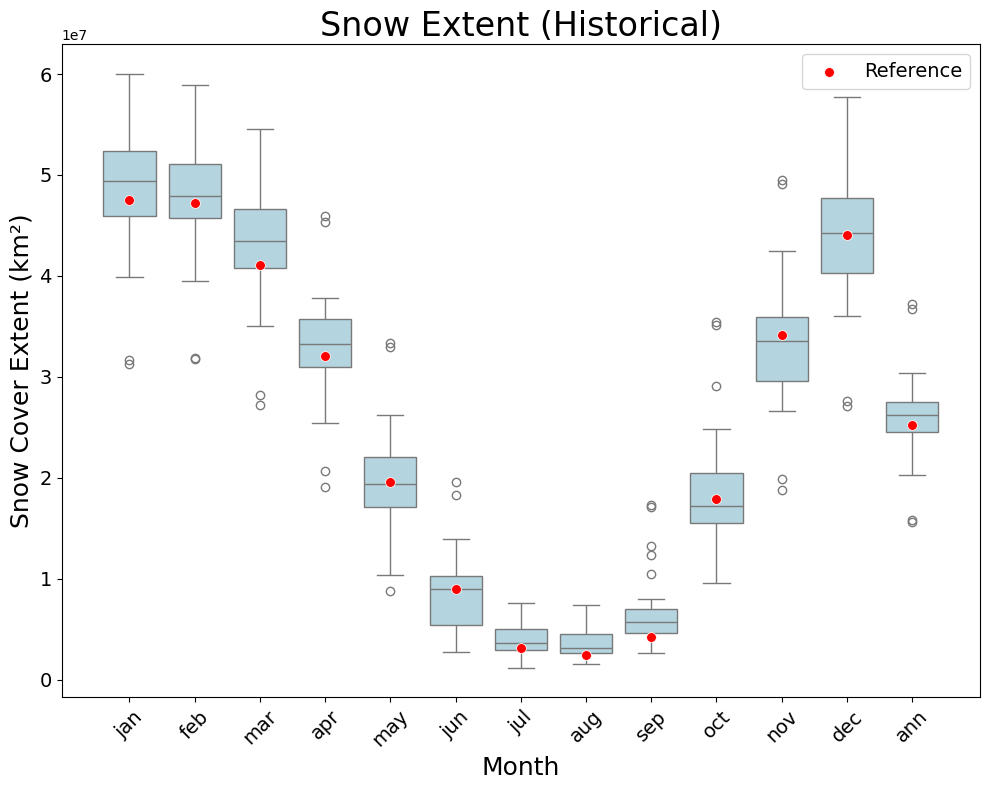

In [16]:
plot_monthly_snow_boxplot(
    df_long=snow_hist_long,
    reference_df=ref_data,
    title="Snow Extent (Historical)",
    save_path=None  # ou "figures/historical_snow_extent.png"
)

Sur cette figure on remarque que la référence (points rouges) se situe assez bien dans les intervalles créés par les modèles, ce qui montre une cohérence entre réalité et simulations. Néanmoins, on remarque également que de nombreux points se situent hors des intervalles créés par les boxplots, ces points sont les outliers de cette analyse.

### Détermination des outliers

In [17]:
# calcul des outliers présents sur la figure au-dessus
outliers = []

# detection des outliers pour chaque mois
for mois in snow_hist_long['Month'].unique():
    valeurs = snow_hist_long[snow_hist_long['Month'] == mois]['snow_extent']
    q1 = valeurs.quantile(0.25)
    q3 = valeurs.quantile(0.75)
    iqr = q3 - q1 #(interquantile range)
    seuil_bas = q1 - 1.5 * iqr
    seuil_haut = q3 + 1.5 * iqr

    # selection des outliers
    outliers_mois = snow_hist_long[
        (snow_hist_long['Month'] == mois) &
        ((snow_hist_long['snow_extent'] < seuil_bas) | (snow_hist_long['snow_extent'] > seuil_haut))
    ]
    outliers.append(outliers_mois)

outliers_df = pd.concat(outliers)

In [18]:
outliers_df

,modèle,Month,snow_extent
15,MPI-ESM1-2-LR,jan,3.125102e+07
23,MPI-ESM1-2-HR,jan,3.170003e+07
41,MPI-ESM1-2-LR,feb,3.181366e+07
49,MPI-ESM1-2-HR,feb,3.174476e+07
67,MPI-ESM1-2-LR,mar,2.820279e+07
75,MPI-ESM1-2-HR,mar,2.720010e+07
78,EC-Earth3-Veg,apr,4.531498e+07
88,EC-Earth3,apr,4.589171e+07
93,MPI-ESM1-2-LR,apr,2.067369e+07
101,MPI-ESM1-2-HR,apr,1.912685e+07


Ce tableau indique quels sont les modèles situés hors de l'intervalle, en précisant pour quel mois et avec quelle valeur de couverture neigeuse.

### Calcul des erreurs absolues

In [19]:
# création d'un nouveau df
df_avec_erreur = snow_hist_long.merge(ref_data, on='Month', how='left')
df_avec_erreur

,modèle_x,Month,snow_extent_x,modèle_y,snow_extent_y
0,EC-Earth3-Veg,jan,5.953257e+07,reference,4.752734e+07
1,CNRM-ESM2-1,jan,5.369965e+07,reference,4.752734e+07
2,MIROC6,jan,5.266020e+07,reference,4.752734e+07
3,CIESM,jan,4.772395e+07,reference,4.752734e+07
4,CNRM-CM6-1-HR,jan,5.424420e+07,reference,4.752734e+07
...,...,...,...,...,...
333,CESM2-WACCM,ann,2.367281e+07,reference,2.517929e+07
334,CESM2,ann,2.326732e+07,reference,2.517929e+07
335,MPI-ESM1-2-HR,ann,1.560419e+07,reference,2.517929e+07
336,GFDL-CM4,ann,2.022010e+07,reference,2.517929e+07


In [20]:
# calcul de l'erreur absolue (neige simulée - neige de référence)
df_avec_erreur['Erreur_absolue'] = (df_avec_erreur['snow_extent_x'] - df_avec_erreur['snow_extent_y']).abs()

#### Visualisation sous forme de heatmap

In [21]:
# je force l'ordre des mois, sinon classe par ordre alphabétique
ordre_mois = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 
              'sep', 'oct', 'nov', 'dec', 'ann']

# je réorganise mes données de format long à large
df_absolu = df_avec_erreur[df_avec_erreur['modèle_x'] !='reference'].pivot(index='modèle_x', columns='Month', values='Erreur_absolue')
df_absolu = df_absolu[ordre_mois]

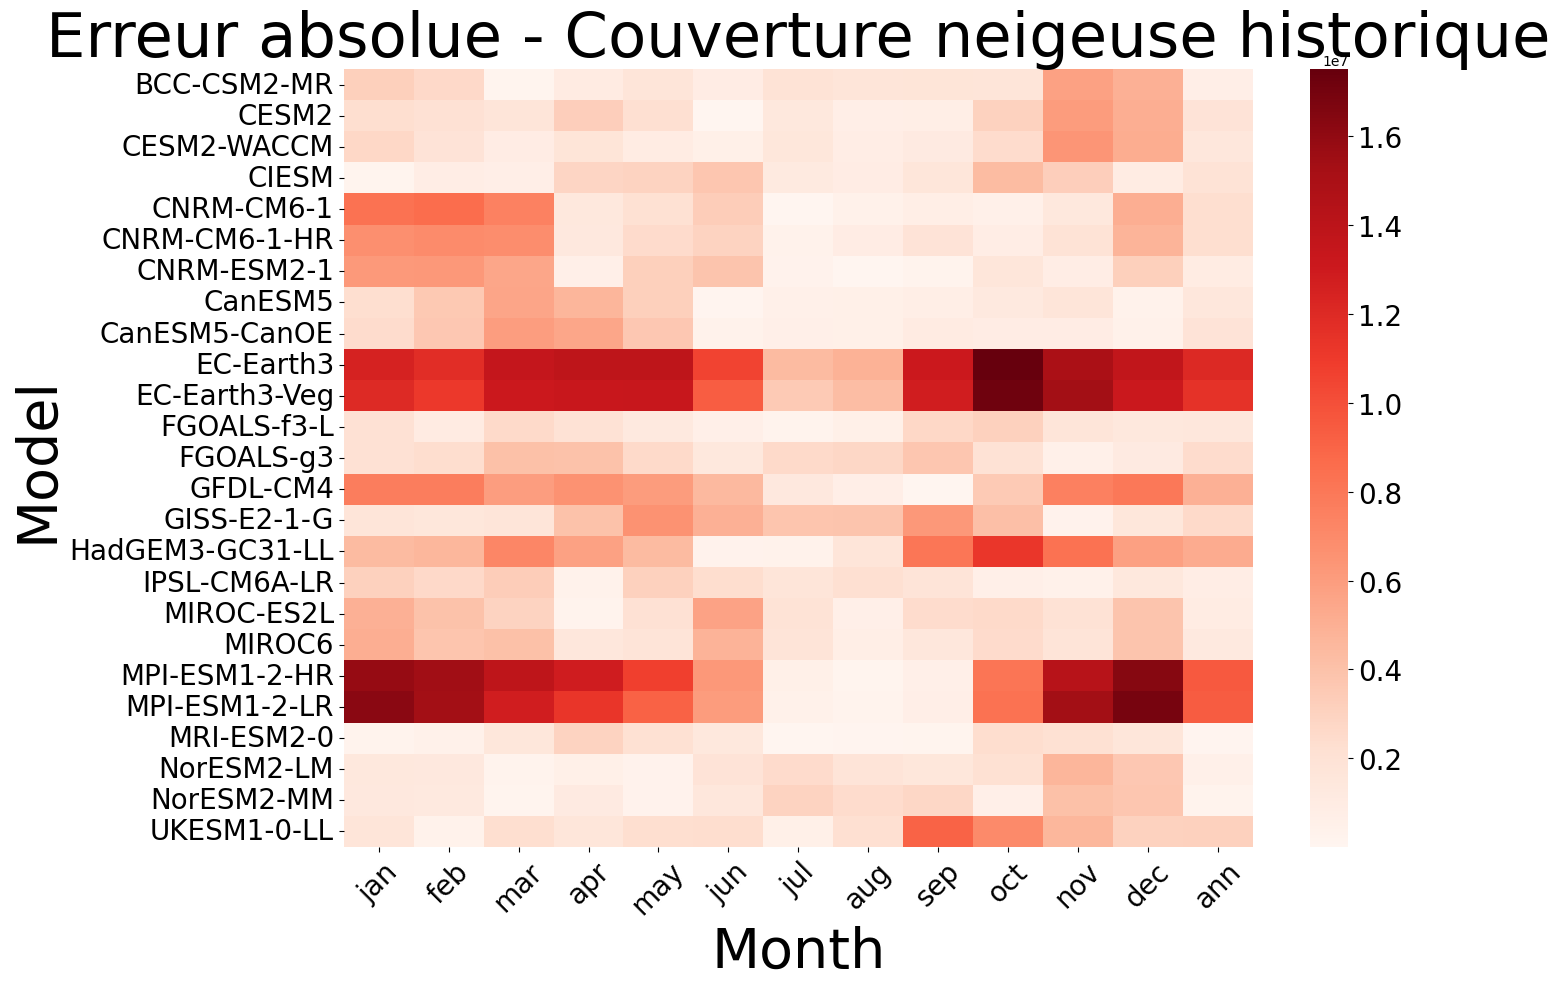

In [28]:
plot_heatmap_errors(
    data=df_absolu,
    title="Erreur absolue - Couverture neigeuse historique",
    #xlabel="Month",
    #ylabel="Model",
    #cmap="Reds",
    #annot=False,
    fontsize_title=45,
    fontsize_labels=40,
    fontsize_ticks=20,
    save_path=None  # ou 'figures/absolute_error_historical.png'
)

Cette figure présente les erreurs absolues de couverture neigeuse par rapport à la référence obtenues par le calcul. Cette visualisation permet d'avoir un aperçu rapide des modèles et des mois pour lesquels la neige est mal simulée (zones très rouges). Ici, on va que notamment 2 groupes de modèles la simulent mal (EC-Earth et MPI-ESM1-2). C'est utile de le savoir afin de les prendre moins en considération dans les analyses futures.

### Calcul des erreurs relatives

In [24]:
# Calcul des erreurs relatives (en %)
df_avec_erreur['Erreur_relative'] = (((df_avec_erreur['snow_extent_x'] - df_avec_erreur['snow_extent_y'])/df_avec_erreur['snow_extent_y'])*100).abs()

#### Visualisation sous forme de heatmap

In [25]:
# je réorganise mes données de format long à large
df_relative = df_avec_erreur[df_avec_erreur['modèle_x'] !='reference'].pivot(index='modèle_x', columns='Month', values='Erreur_relative')
df_relative = df_relative[ordre_mois]

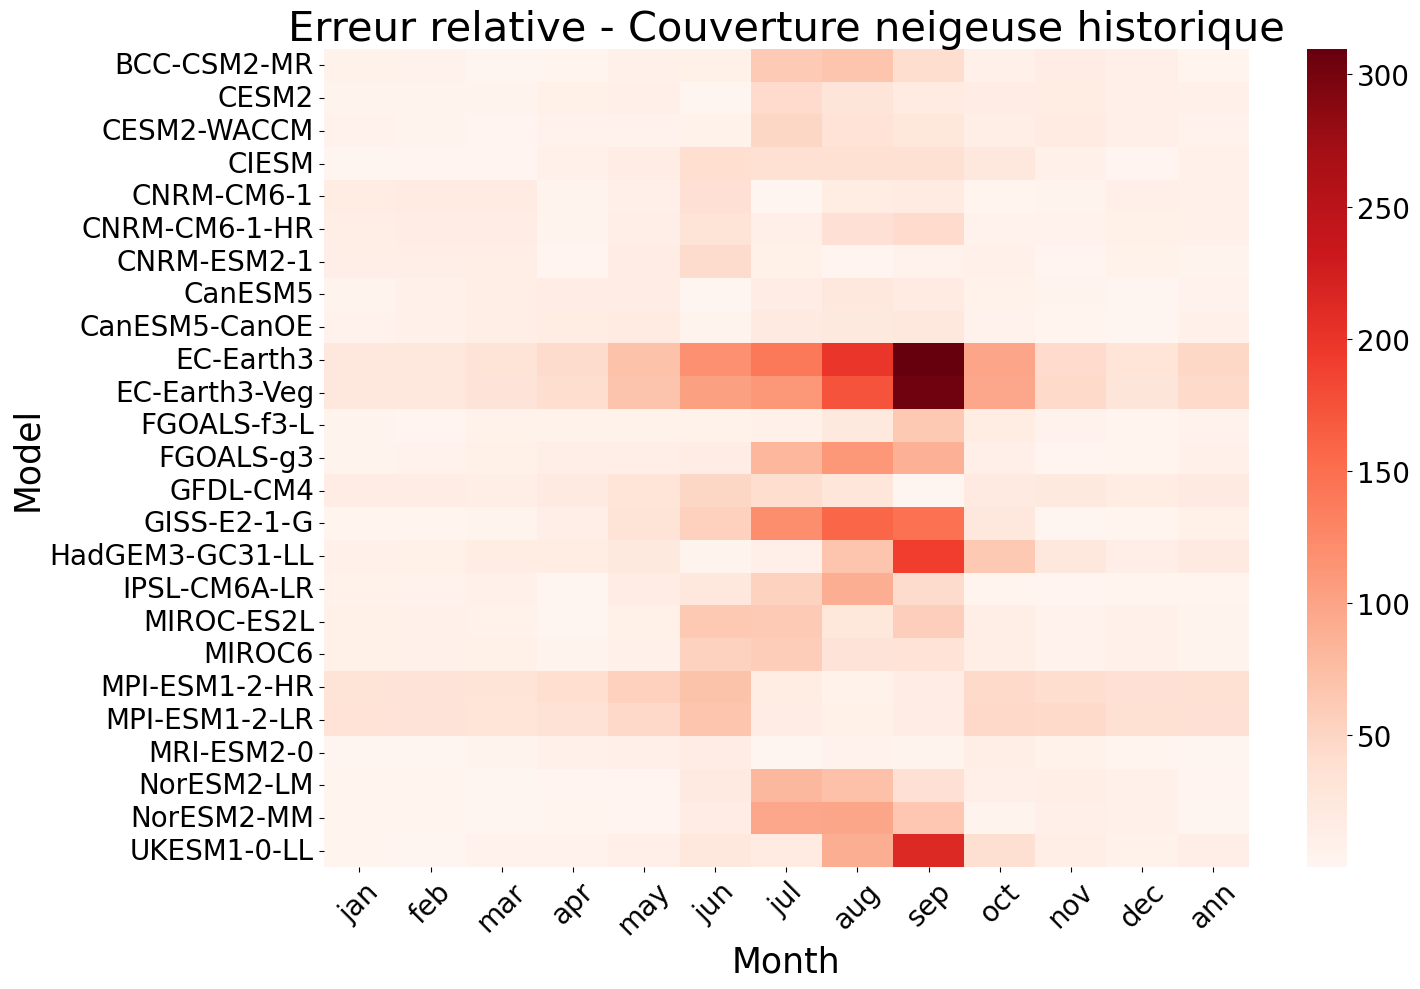

In [33]:
plot_heatmap_errors(
    data=df_relative,
    title="Erreur relative - Couverture neigeuse historique",
    fontsize_title=30,
    fontsize_labels=25,
    fontsize_ticks=20,
    save_path=None  # ou 'figures/absolute_error_historical.png'
)

Cette figure présente cette fois les erreurs relatives. On remarque qu'elles sont notamment importantes pendant l'été pour une grande majorité des modèles. Et de manière annuelle, ce sont les mêmes modèles que précédemment qui ont cette erreur la plus importante.

## Détermination du classement de chaque modèle

Afin de savoir quels sont les meilleurs et les pires modèles, on en fait un classement, selon leurs erreurs absolues.

In [35]:
erreurs_absolues_mensuelles_hist = df_absolu.drop(columns=['ann'])
erreurs_absolues_mensuelles_hist.tail()

Month,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
modèle_x,,,,,,,,,,,,
MPI-ESM1-2-LR,1.627631e+07,1.535703e+07,1.283148e+07,1.134046e+07,9.163899e+06,6.051203e+06,4.605887e+05,2.492710e+05,7.028639e+05,8.319699e+06,1.536306e+07,1.691201e+07
MRI-ESM2-0,2.728096e+05,4.150116e+05,1.570946e+06,2.981525e+06,2.156461e+06,1.393279e+06,1.933865e+04,1.290249e+05,1.570928e+05,2.394788e+06,2.134144e+06,1.579312e+06
NorESM2-LM,1.388927e+06,1.321705e+06,2.644078e+05,5.893945e+05,3.019196e+05,1.916460e+06,2.528796e+06,1.784357e+06,1.558269e+06,2.156828e+06,4.722039e+06,3.680336e+06
NorESM2-MM,1.361964e+06,1.266455e+06,1.626014e+05,1.146634e+06,3.124203e+05,1.505824e+06,3.001150e+06,2.400936e+06,2.741986e+06,6.858776e+05,4.099914e+06,3.742342e+06
UKESM1-0-LL,1.651814e+06,4.112674e+05,2.288024e+06,1.631201e+06,2.290977e+06,2.393157e+06,5.943325e+05,2.208984e+06,9.044087e+06,7.003168e+06,4.588204e+06,3.066099e+06


In [36]:
classement_modeles = erreurs_absolues_mensuelles_hist.mean(axis=1)

In [37]:
classement_modeles.sort_values(ascending=True, inplace=True)
print(classement_modeles)

modèle_x
MRI-ESM2-0         1.266978e+06
FGOALS-f3-L        1.609116e+06
NorESM2-LM         1.851120e+06
NorESM2-MM         1.869009e+06
IPSL-CM6A-LR       1.927405e+06
CIESM              1.962490e+06
CanESM5            2.056824e+06
CanESM5-CanOE      2.183057e+06
CESM2-WACCM        2.201267e+06
BCC-CSM2-MR        2.286914e+06
CESM2              2.395764e+06
FGOALS-g3          2.430790e+06
CNRM-ESM2-1        2.649459e+06
MIROC6             2.782514e+06
MIROC-ES2L         2.791986e+06
UKESM1-0-LL        3.097610e+06
CNRM-CM6-1-HR      3.176870e+06
CNRM-CM6-1         3.299169e+06
GISS-E2-1-G        3.367435e+06
GFDL-CM4           4.964078e+06
HadGEM3-GC31-LL    5.206403e+06
MPI-ESM1-2-LR      9.418989e+06
MPI-ESM1-2-HR      9.600430e+06
EC-Earth3-Veg      1.154588e+07
EC-Earth3          1.205517e+07
dtype: float64


Ici, les modèles sont classés selon leur valeur d'erreur absolue, de manière décroissante. Le premier modèle correspond au modèle avec la plus faible erreur et inversement.

## Attribution d'un score à chaque modèle

A partir des erreurs absolues moyennes, on peut attribuer un classement à chaque modèle. Deux fonctions de score différentes ont été testées : la fonction exponentielle et une fonction de type Gaussienne.

### Exponentielle décroissante

In [38]:
min_val = classement_modeles.min()
max_val = classement_modeles.max()

In [39]:
scores_exp = np.exp(-(classement_modeles - min_val)/(max_val - min_val))
scores_exp

modèle_x
MRI-ESM2-0         1.000000
FGOALS-f3-L        0.968783
NorESM2-LM         0.947293
NorESM2-MM         0.945724
IPSL-CM6A-LR       0.940619
CIESM              0.937564
CanESM5            0.929402
CanESM5-CanOE      0.918590
CESM2-WACCM        0.917041
BCC-CSM2-MR        0.909790
CESM2              0.900656
FGOALS-g3          0.897737
CNRM-ESM2-1        0.879724
MIROC6             0.868940
MIROC-ES2L         0.868178
UKESM1-0-LL        0.843928
CNRM-CM6-1-HR      0.837750
CNRM-CM6-1         0.828307
GISS-E2-1-G        0.823082
GFDL-CM4           0.709852
HadGEM3-GC31-LL    0.694085
MPI-ESM1-2-LR      0.469709
MPI-ESM1-2-HR      0.461875
EC-Earth3-Veg      0.385663
EC-Earth3          0.367879
dtype: float64

### Gaussienne "arrangée"

In [40]:
mu = classement_modeles.min()
sigma = (classement_modeles.max() - classement_modeles.min())/4

In [42]:
scores_gauss = np.exp(-((classement_modeles - mu) ** 2)/(2 * sigma **2))
scores_gauss

modèle_x
MRI-ESM2-0         1.000000
FGOALS-f3-L        0.991986
NorESM2-LM         0.976818
NorESM2-MM         0.975395
IPSL-CM6A-LR       0.970464
CIESM              0.967296
CanESM5            0.958024
CanESM5-CanOE      0.943948
CESM2-WACCM        0.941764
BCC-CSM2-MR        0.930991
CESM2              0.916144
FGOALS-g3          0.911101
CNRM-ESM2-1        0.876889
MIROC6             0.853953
MIROC-ES2L         0.852264
UKESM1-0-LL        0.794253
CNRM-CM6-1-HR      0.778231
CNRM-CM6-1         0.752864
GISS-E2-1-G        0.738404
GFDL-CM4           0.390808
HadGEM3-GC31-LL    0.344129
MPI-ESM1-2-LR      0.010379
MPI-ESM1-2-HR      0.008450
EC-Earth3-Veg      0.000701
EC-Earth3          0.000335
dtype: float64

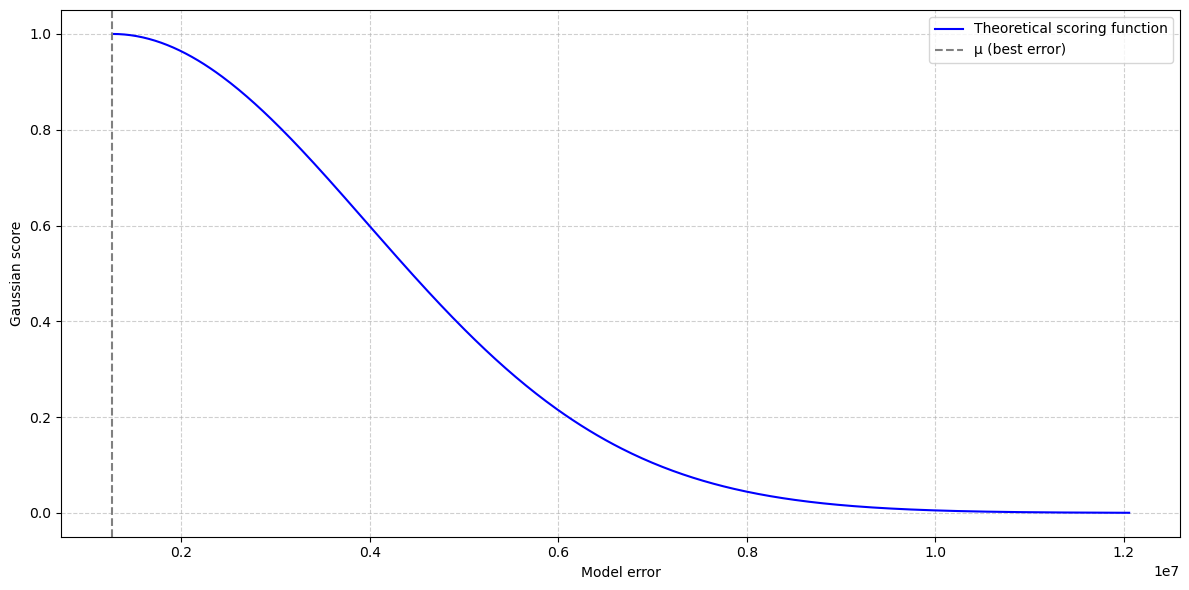

In [43]:
# Générer la courbe théorique
x = np.linspace(classement_modeles.min(), classement_modeles.max(), 500)
gauss_curve = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Tracé
plt.figure(figsize=(12, 6))
plt.plot(x, gauss_curve, label='Theoretical scoring function', color='blue')
plt.axvline(mu, color='gray', linestyle='--', label='μ (best error)')
plt.xlabel("Model error")
plt.ylabel("Gaussian score")
#plt.title("Transformation Gaussienne des Erreurs des Modèles")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.savefig("courbe_gaussienne.png")
plt.show()

### Création d'un dataframe

In [44]:
scores_modeles = pd.DataFrame({
    'Erreur_moyenne' : classement_modeles,
    'Scores_exp' : scores_exp,
    'Scores_gauss' : scores_gauss,
})

In [45]:
scores_modeles

,Erreur_moyenne,Scores_exp,Scores_gauss
modèle_x,,,
MRI-ESM2-0,1.266978e+06,1.000000,1.000000
FGOALS-f3-L,1.609116e+06,0.968783,0.991986
NorESM2-LM,1.851120e+06,0.947293,0.976818
NorESM2-MM,1.869009e+06,0.945724,0.975395
IPSL-CM6A-LR,1.927405e+06,0.940619,0.970464
CIESM,1.962490e+06,0.937564,0.967296
CanESM5,2.056824e+06,0.929402,0.958024
CanESM5-CanOE,2.183057e+06,0.918590,0.943948
CESM2-WACCM,2.201267e+06,0.917041,0.941764


In [46]:
scores_modeles.to_csv("scores_modeles.csv")